In [1]:
import os
import argparse

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

In [3]:
import torchvision
import torchvision.transforms as transforms

In [50]:
import matplotlib.pyplot as plt
from utils import progress_bar

In [4]:
torch.cuda.is_available()

True

In [6]:
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [7]:
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

100%|██████████████████████████████████████████████████████████████▉| 170450944/170498071 [00:17<00:00, 9370674.78it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data


170500096it [00:30, 9370674.78it/s]                                                                                    

In [10]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

Files already downloaded and verified


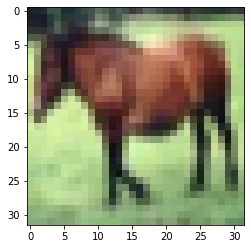

horse


In [53]:
plt.figure()
plt.imshow(trainset.data[7])
plt.grid(False)
plt.show()

print(trainset.classes[7])

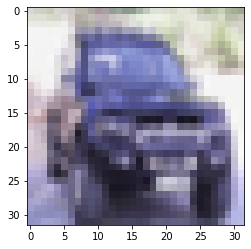

truck


In [64]:
plt.figure()
plt.imshow(testset.data[9])
plt.grid(False)
plt.show()

print(testset.classes[9])

In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

In [19]:
vgg16_layers= [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

In [20]:
class VGG(nn.Module):
    def __init__(self):
        super(self).__init__()
        self.features = self.make_layers(vgg16_layers)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

    def make_layers(self, cfg):
        model = []
        in_channels = 3
        for layer_type in cfg:
            if layer_type == 'M':
                model += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                model += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), nn.BatchNorm2d(x), nn.ReLU(inplace=True)]
                in_channels = layer_type
        model += [nn.AvgPool2d(kernel_size=1, stride=1)]
        # Return the pointer to the model
        return nn.Sequential(*model)


In [21]:
model = VGG()
model = model.to('cuda')

In [34]:
model = torch.nn.DataParallel(model)
cudnn.benchmark = True

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.105, momentum=0.9, weight_decay=6e-3)

In [38]:
def train(epoch):
    print('\nEpoch: ' + str(epoch))
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.4f | Acc: %.4f%% (%d/%d)'% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

In [42]:
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Save the training checkpoint 
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving chkpt')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [44]:
for epoch in range(0, 10):
    train(epoch)
    test(epoch)


Epoch: 0


 [================================================================>]  Step: 70ms | Tot: 35s291ms | Loss: 0.704 | Acc: 76.534% (38267/5000 391/391 =========================================>.............]  Step: 103ms | Tot: 27s970ms | Loss: 0.701 | Acc: 76.537% (30370/3968 310/391 ========================================>.............]  Step: 81ms | Tot: 28s52ms | Loss: 0.702 | Acc: 76.527% (30464/3980 311/391 ===================================================>.............]  Step: 96ms | Tot: 28s149ms | Loss: 0.702 | Acc: 76.520% (30559/3993 312/391 ================================>.............]  Step: 88ms | Tot: 28s238ms | Loss: 0.703 | Acc: 76.505% (30651/4006 313/391 314/391 ======================================>............]  Step: 89ms | Tot: 28s509ms | Loss: 0.702 | Acc: 76.503% (30944/4044 316/391 ====================================================>............]  Step: 90ms | Tot: 28s600ms | Loss: 0.702 | Acc: 76.513% (31046/4057 317/391 ====================================

 [============================================================>....]  Step: 26ms | Tot: 2s473ms | Loss: 1.130 | Acc: 64.947% (6105/940 94/100 =================================================>...............]  Step: 26ms | Tot: 2s29ms | Loss: 1.119 | Acc: 65.273% (5026/770 77/100 ==================================================>..............]  Step: 26ms | Tot: 2s56ms | Loss: 1.121 | Acc: 65.218% (5087/780 78/100 ==================================================>..............]  Step: 24ms | Tot: 2s80ms | Loss: 1.118 | Acc: 65.278% (5157/790 79/100 ===================================================>.............]  Step: 25ms | Tot: 2s106ms | Loss: 1.118 | Acc: 65.287% (5223/800 80/100 ====================================================>............]  Step: 25ms | Tot: 2s132ms | Loss: 1.116 | Acc: 65.358% (5294/810 81/100 =====================================================>...........]  Step: 24ms | Tot: 2s182ms | Loss: 1.123 | Acc: 65.133% (5406/830 83/100 =====================

 [================================================================>]  Step: 75ms | Tot: 35s289ms | Loss: 0.659 | Acc: 78.068% (39034/5000 391/391 =================================================>...............]  Step: 90ms | Tot: 26s979ms | Loss: 0.655 | Acc: 78.277% (29958/3827 299/391 =================================================>...............]  Step: 89ms | Tot: 27s69ms | Loss: 0.655 | Acc: 78.276% (30058/3840 300/391 ======================>...............]  Step: 92ms | Tot: 27s162ms | Loss: 0.655 | Acc: 78.276% (30158/3852 301/391 =========================================>..............]  Step: 90ms | Tot: 27s343ms | Loss: 0.656 | Acc: 78.282% (30361/3878 303/391 =============================================>..............]  Step: 91ms | Tot: 27s435ms | Loss: 0.656 | Acc: 78.274% (30458/3891 304/391 ============================================>..............]  Step: 90ms | Tot: 27s526ms | Loss: 0.656 | Acc: 78.261% (30553/3904 305/39 306/391 ===============================

 [===============================================================>.]  Step: 27ms | Tot: 2s607ms | Loss: 0.839 | Acc: 71.505% (7079/990 99/100 =====================================================>...........]  Step: 27ms | Tot: 2s213ms | Loss: 0.844 | Acc: 71.357% (5994/840 84/100 ======================================================>..........]  Step: 25ms | Tot: 2s239ms | Loss: 0.845 | Acc: 71.365% (6066/850 85/100 ========================================>.........]  Step: 27ms | Tot: 2s267ms | Loss: 0.844 | Acc: 71.384% (6139/860 86/100 =======================================================>.........]  Step: 25ms | Tot: 2s293ms | Loss: 0.846 | Acc: 71.333% (6206/870 87/100 ========================================================>........]  Step: 25ms | Tot: 2s319ms | Loss: 0.845 | Acc: 71.364% (6280/880 88/100 ===================================================>.......]  Step: 25ms | Tot: 2s345ms | Loss: 0.846 | Acc: 71.303% (6346/890 89/100 =======================================

 [================================================================>]  Step: 65ms | Tot: 35s251ms | Loss: 0.622 | Acc: 79.304% (39652/5000 391/391  ===============================================>................]  Step: 95ms | Tot: 26s544ms | Loss: 0.620 | Acc: 79.424% (29889/3763 294/391 ================================>................]  Step: 91ms | Tot: 26s635ms | Loss: 0.620 | Acc: 79.433% (29994/3776 295/391 ====>...............]  Step: 95ms | Tot: 26s822ms | Loss: 0.620 | Acc: 79.424% (30194/3801 297/391 =================================================>...............]  Step: 89ms | Tot: 26s911ms | Loss: 0.620 | Acc: 79.441% (30302/3814 298/391 =================================================>...............]  Step: 89ms | Tot: 27s1ms | Loss: 0.620 | Acc: 79.437% (30402/3827 299/391 =================================================>...............]  Step: 88ms | Tot: 27s90ms | Loss: 0.620 | Acc: 79.435% (30503/3840 300/391 ============================>..............]  Step: 84

 [======================================================>..........]  Step: 25ms | Tot: 2s245ms | Loss: 0.758 | Acc: 74.400% (6324/850 85/100 =================================================>..............]  Step: 24ms | Tot: 2s64ms | Loss: 0.762 | Acc: 74.282% (5794/780 78/100 =========================================>..............]  Step: 26ms | Tot: 2s91ms | Loss: 0.761 | Acc: 74.316% (5871/790 79/100 ===================================================>.............]  Step: 24ms | Tot: 2s116ms | Loss: 0.761 | Acc: 74.350% (5948/800 80/100 ====================================================>............]  Step: 25ms | Tot: 2s141ms | Loss: 0.760 | Acc: 74.395% (6026/810 81/100 ==========================================>............]  Step: 26ms | Tot: 2s168ms | Loss: 0.759 | Acc: 74.415% (6102/820 82/100 =====================================================>...........]  Step: 25ms | Tot: 2s194ms | Loss: 0.758 | Acc: 74.434% (6178/830 83/100 ========================================

 [================================================================>]  Step: 67ms | Tot: 35s250ms | Loss: 0.601 | Acc: 80.044% (40022/5000 391/391 ==================================================>..............]  Step: 89ms | Tot: 27s402ms | Loss: 0.605 | Acc: 79.942% (31107/3891 304/391 ===============================================>..............]  Step: 91ms | Tot: 27s494ms | Loss: 0.605 | Acc: 79.949% (31212/3904 305/391 ==================================================>..............]  Step: 90ms | Tot: 27s676ms | Loss: 0.604 | Acc: 79.970% (31425/3929 307/391 ===================================================>.............]  Step: 91ms | Tot: 27s768ms | Loss: 0.605 | Acc: 79.974% (31529/3942 308/391 =========================================>.............]  Step: 90ms | Tot: 27s859ms | Loss: 0.605 | Acc: 79.976% (31632/3955 309/391 310/391 ===================>.............]  Step: 91ms | Tot: 28s219ms | Loss: 0.604 | Acc: 79.977% (32042/4006 313/391 ===========================

 [==============================================================>..]  Step: 26ms | Tot: 2s589ms | Loss: 0.768 | Acc: 75.072% (7282/970 97/100 ===============================================>................]  Step: 25ms | Tot: 2s36ms | Loss: 0.761 | Acc: 75.513% (5739/760 76/100 =========================================>...............]  Step: 26ms | Tot: 2s63ms | Loss: 0.762 | Acc: 75.442% (5809/770 77/100 ==================================================>..............]  Step: 25ms | Tot: 2s89ms | Loss: 0.760 | Acc: 75.487% (5888/780 78/100 ==================================================>..............]  Step: 25ms | Tot: 2s115ms | Loss: 0.761 | Acc: 75.468% (5962/790 79/100 ===================================================>.............]  Step: 25ms | Tot: 2s141ms | Loss: 0.762 | Acc: 75.388% (6031/800 80/100 ====================================================>............]  Step: 25ms | Tot: 2s166ms | Loss: 0.761 | Acc: 75.383% (6106/810 81/100 ==============================

 [================================================================>]  Step: 67ms | Tot: 35s212ms | Loss: 0.589 | Acc: 80.462% (40231/5000 391/391  4/391 ==================================================>..............]  Step: 87ms | Tot: 27s465ms | Loss: 0.589 | Acc: 80.405% (31390/3904 305/391 ==================================================>..............]  Step: 91ms | Tot: 27s557ms | Loss: 0.590 | Acc: 80.400% (31491/3916 306/391 =====================================>..............]  Step: 91ms | Tot: 27s649ms | Loss: 0.590 | Acc: 80.395% (31592/3929 307/391 ===================================================>.............]  Step: 90ms | Tot: 27s740ms | Loss: 0.590 | Acc: 80.390% (31693/3942 308/391 ===================>.............]  Step: 92ms | Tot: 27s832ms | Loss: 0.590 | Acc: 80.400% (31800/3955 309/391 ===================================================>.............]  Step: 88ms | Tot: 28s10ms | Loss: 0.590 | Acc: 80.419% (32013/3980 311/391 =============================

 [================================================================>]  Step: 27ms | Tot: 2s677ms | Loss: 0.706 | Acc: 76.960% (7696/1000 100/100 ===================================================>...........]  Step: 25ms | Tot: 2s255ms | Loss: 0.710 | Acc: 76.774% (6449/840 84/100 ======================================================>..........]  Step: 24ms | Tot: 2s280ms | Loss: 0.710 | Acc: 76.729% (6522/850 85/100 =======================================================>.........]  Step: 25ms | Tot: 2s306ms | Loss: 0.708 | Acc: 76.814% (6606/860 86/100 =============================================>.........]  Step: 27ms | Tot: 2s334ms | Loss: 0.709 | Acc: 76.816% (6683/870 87/100 ========================================================>........]  Step: 25ms | Tot: 2s359ms | Loss: 0.709 | Acc: 76.830% (6761/880 88/100 =========================================================>.......]  Step: 25ms | Tot: 2s385ms | Loss: 0.708 | Acc: 76.876% (6842/890 89/100 ============================

 [================================================================>]  Step: 74ms | Tot: 35s261ms | Loss: 0.556 | Acc: 81.630% (40815/5000 391/391 95/391 =================================================>...............]  Step: 88ms | Tot: 26s692ms | Loss: 0.552 | Acc: 81.643% (30933/3788 296/391 ========================>...............]  Step: 92ms | Tot: 26s784ms | Loss: 0.552 | Acc: 81.660% (31044/3801 297/391 =================================================>...............]  Step: 102ms | Tot: 26s973ms | Loss: 0.551 | Acc: 81.681% (31261/3827 299/391 =================================================>...............]  Step: 82ms | Tot: 27s55ms | Loss: 0.551 | Acc: 81.677% (31364/3840 300/391 =======================================>..............]  Step: 98ms | Tot: 27s244ms | Loss: 0.551 | Acc: 81.700% (31582/3865 302/391 =============================================>..............]  Step: 95ms | Tot: 27s516ms | Loss: 0.550 | Acc: 81.739% (31911/3904 305/391 ========================

 [=============================================================>...]  Step: 25ms | Tot: 2s520ms | Loss: 0.717 | Acc: 75.947% (7215/950 95/100 ===================================>.......]  Step: 27ms | Tot: 2s364ms | Loss: 0.717 | Acc: 75.910% (6756/890 89/100 =========================================================>.......]  Step: 23ms | Tot: 2s388ms | Loss: 0.718 | Acc: 75.889% (6830/900 90/100 ==========================================================>......]  Step: 27ms | Tot: 2s416ms | Loss: 0.720 | Acc: 75.824% (6900/910 91/100 =========================================>.....]  Step: 26ms | Tot: 2s443ms | Loss: 0.716 | Acc: 75.935% (6986/920 92/100 ===========================================================>.....]  Step: 25ms | Tot: 2s468ms | Loss: 0.716 | Acc: 75.946% (7063/930 93/100 ============================================================>....]  Step: 25ms | Tot: 2s494ms | Loss: 0.716 | Acc: 75.957% (7140/940 94/100 ==========================================================

 [=================>...............................................]  Step: 76ms | Tot: 9s124ms | Loss: 0.537 | Acc: 82.070% (10715/1305 102/391 ................................]  Step: 90ms | Tot: 183ms | Loss: 0.543 | Acc: 81.510% (313/38 3/391 ...................................]  Step: 91ms | Tot: 274ms | Loss: 0.507 | Acc: 83.594% (428/51 4/391 .........................]  Step: 94ms | Tot: 539ms | Loss: 0.542 | Acc: 82.254% (737/89 7/391 ............................................]  Step: 101ms | Tot: 641ms | Loss: 0.535 | Acc: 82.227% (842/102 8/391 ....................................................]  Step: 83ms | Tot: 806ms | Loss: 0.528 | Acc: 82.500% (1056/128 10/391 =>...............................................................]  Step: 97ms | Tot: 903ms | Loss: 0.530 | Acc: 82.386% (1160/140 11/391 =>...............................................................]  Step: 91ms | Tot: 994ms | Loss: 0.541 | Acc: 82.031% (1260/153 12/391 =>..................................

 [================================================================>]  Step: 74ms | Tot: 35s193ms | Loss: 0.545 | Acc: 81.856% (40928/5000 391/391 ======================================================>..........]  Step: 90ms | Tot: 29s607ms | Loss: 0.543 | Acc: 81.832% (34461/4211 329/391 ====================================>..........]  Step: 92ms | Tot: 29s699ms | Loss: 0.543 | Acc: 81.837% (34568/4224 330/391 =======================================================>.........]  Step: 91ms | Tot: 29s968ms | Loss: 0.543 | Acc: 81.851% (34888/4262 333/391 =======================================================>.........]  Step: 101ms | Tot: 30s234ms | Loss: 0.543 | Acc: 81.848% (35201/4300 336/39 337/391 ========================================================>........]  Step: 90ms | Tot: 30s593ms | Loss: 0.544 | Acc: 81.841% (35617/4352 340/391 ========================================================>........]  Step: 97ms | Tot: 30s772ms | Loss: 0.543 | Acc: 81.849% (35830/4377 342/391 

 [=========================================================>.......]  Step: 25ms | Tot: 2s381ms | Loss: 0.753 | Acc: 75.622% (6806/900 90/100 ====================================================>............]  Step: 25ms | Tot: 2s172ms | Loss: 0.744 | Acc: 75.854% (6220/820 82/100 =====================================================>...........]  Step: 25ms | Tot: 2s198ms | Loss: 0.747 | Acc: 75.783% (6290/830 83/100 ===================================>...........]  Step: 27ms | Tot: 2s226ms | Loss: 0.749 | Acc: 75.738% (6362/840 84/100 ======================================================>..........]  Step: 25ms | Tot: 2s252ms | Loss: 0.751 | Acc: 75.659% (6431/850 85/100 =======================================================>.........]  Step: 25ms | Tot: 2s277ms | Loss: 0.751 | Acc: 75.616% (6503/860 86/100 ===================================================>.........]  Step: 25ms | Tot: 2s303ms | Loss: 0.751 | Acc: 75.621% (6579/870 87/100 ========================================

 [================================================================>]  Step: 74ms | Tot: 35s296ms | Loss: 0.532 | Acc: 82.332% (41166/5000 391/391 =============================>...........]  Step: 102ms | Tot: 29s142ms | Loss: 0.533 | Acc: 82.276% (34016/4134 323/391 =====================================================>...........]  Step: 89ms | Tot: 29s232ms | Loss: 0.532 | Acc: 82.289% (34127/4147 324/391 ======================================================>..........]  Step: 92ms | Tot: 29s493ms | Loss: 0.533 | Acc: 82.311% (34452/4185 327/391 ======================================================>..........]  Step: 98ms | Tot: 29s771ms | Loss: 0.534 | Acc: 82.266% (34749/4224 330/391 ======================================================>..........]  Step: 81ms | Tot: 29s852ms | Loss: 0.534 | Acc: 82.255% (34850/4236 331/391 =======================================================>.........]  Step: 97ms | Tot: 29s950ms | Loss: 0.534 | Acc: 82.264% (34959/4249 332/391 =============

 [==============================================================>..]  Step: 24ms | Tot: 2s534ms | Loss: 1.051 | Acc: 68.175% (6613/970 97/100 ================================================>................]  Step: 25ms | Tot: 1s985ms | Loss: 1.060 | Acc: 67.895% (5160/760 76/100 =================================================>...............]  Step: 25ms | Tot: 2s11ms | Loss: 1.059 | Acc: 67.896% (5228/770 77/100 ==================================================>..............]  Step: 26ms | Tot: 2s37ms | Loss: 1.061 | Acc: 67.885% (5295/780 78/100 ==================================================>..............]  Step: 26ms | Tot: 2s63ms | Loss: 1.058 | Acc: 67.975% (5370/790 79/100 ===================================================>.............]  Step: 24ms | Tot: 2s88ms | Loss: 1.057 | Acc: 68.000% (5440/800 80/100 ===================================>............]  Step: 26ms | Tot: 2s115ms | Loss: 1.056 | Acc: 68.062% (5513/810 81/100 =======================================

 [================================================================>]  Step: 73ms | Tot: 35s181ms | Loss: 0.523 | Acc: 82.574% (41287/5000 391/391 ======>........]  Step: 92ms | Tot: 30s691ms | Loss: 0.523 | Acc: 82.595% (36051/4364 341/391 ========================================================>........]  Step: 98ms | Tot: 30s872ms | Loss: 0.524 | Acc: 82.567% (36250/4390 343/391 =========================================================>.......]  Step: 94ms | Tot: 30s967ms | Loss: 0.523 | Acc: 82.583% (36363/4403 344/39 345/391 =========================================================>.......]  Step: 97ms | Tot: 31s233ms | Loss: 0.524 | Acc: 82.556% (36668/4441 347/391 =========================================================>.......]  Step: 90ms | Tot: 31s323ms | Loss: 0.524 | Acc: 82.543% (36768/4454 348/391 ==============>......]  Step: 104ms | Tot: 31s511ms | Loss: 0.524 | Acc: 82.536% (36976/4480 350/391 =====================================>......]  Step: 81ms | Tot: 31s592ms | 

 [===============================================================>.]  Step: 31ms | Tot: 2s645ms | Loss: 0.841 | Acc: 74.535% (7379/990 99/100 =======================================================>.........]  Step: 26ms | Tot: 2s321ms | Loss: 0.849 | Acc: 74.253% (6460/870 87/100 ========================================================>........]  Step: 26ms | Tot: 2s347ms | Loss: 0.848 | Acc: 74.273% (6536/880 88/100 =========================================================>.......]  Step: 25ms | Tot: 2s372ms | Loss: 0.845 | Acc: 74.326% (6615/890 89/100 ==========================================================>......]  Step: 22ms | Tot: 2s421ms | Loss: 0.844 | Acc: 74.374% (6768/910 91/100 ============================================================>....]  Step: 31ms | Tot: 2s508ms | Loss: 0.841 | Acc: 74.468% (7000/940 94/100 =============================================================>...]  Step: 26ms | Tot: 2s535ms | Loss: 0.841 | Acc: 74.442% (7072/950 95/100 ==================

 [================================================================>]  Step: 69ms | Tot: 35s250ms | Loss: 0.507 | Acc: 83.164% (41582/5000 391/391 ======================================================>..........]  Step: 97ms | Tot: 29s475ms | Loss: 0.505 | Acc: 83.286% (34860/4185 327/391 ======================================================>..........]  Step: 84ms | Tot: 29s560ms | Loss: 0.505 | Acc: 83.289% (34968/4198 328/391 ===============================================>..........]  Step: 98ms | Tot: 29s750ms | Loss: 0.505 | Acc: 83.258% (35168/4224 330/391 ======================================================>..........]  Step: 92ms | Tot: 29s842ms | Loss: 0.506 | Acc: 83.235% (35265/4236 331/391 =======================================================>.........]  Step: 91ms | Tot: 29s934ms | Loss: 0.506 | Acc: 83.229% (35369/4249 332/391 =======================================================>.........]  Step: 92ms | Tot: 30s201ms | Loss: 0.505 | Acc: 83.223% (35686/4288 335/3

 [===============================================================>.]  Step: 24ms | Tot: 2s599ms | Loss: 0.840 | Acc: 74.404% (7366/990 99/100 ================================================>................]  Step: 25ms | Tot: 2s2ms | Loss: 0.838 | Acc: 74.434% (5657/760 76/100 =================================================>...............]  Step: 25ms | Tot: 2s27ms | Loss: 0.840 | Acc: 74.442% (5732/770 77/100 ==================================================>..............]  Step: 24ms | Tot: 2s78ms | Loss: 0.838 | Acc: 74.544% (5889/790 79/100 ===================================================>.............]  Step: 25ms | Tot: 2s104ms | Loss: 0.837 | Acc: 74.550% (5964/800 80/100 ====================================================>............]  Step: 26ms | Tot: 2s131ms | Loss: 0.834 | Acc: 74.630% (6045/810 81/100 ====================================================>............]  Step: 25ms | Tot: 2s157ms | Loss: 0.833 | Acc: 74.610% (6118/820 82/100 ======================

# References
Loosely based on: https://github.com/kuangliu/pytorch-cifar